# ASL Dataset Quality Check

This notebook performs quality checks on the ASL dataset to verify:
- Dataset structure and organization
- Image file integrity
- Image dimensions and formats
- Class distribution
- Missing or corrupted files

No modifications will be made to the dataset.

## 1. Import Required Libraries

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

## 2. Dataset Path Configuration

In [5]:
# Define the dataset path
# Note: This path is relative to the project root, not the notebook location
DATA_DIR = Path('../data/asl_dataset')

# Verify dataset directory exists
if not DATA_DIR.exists():
    print(f"ERROR: Dataset directory not found at {DATA_DIR}")
    print(f"Absolute path: {DATA_DIR.resolve()}")
else:
    print(f"SUCCESS: Dataset directory found at {DATA_DIR}")
    print(f"Absolute path: {DATA_DIR.resolve()}")

SUCCESS: Dataset directory found at ..\data\asl_dataset
Absolute path: C:\Users\Awsom\Programs\CPSC Capstone\ASL-Audio-Interpreter\data\asl_dataset


## 3. Check Dataset Structure

In [6]:
# Expected classes (0-9 and a-z)
expected_classes = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z') + 1)]
print(f"Expected classes: {expected_classes}")
print(f"Total expected classes: {len(expected_classes)}")

# Get actual classes from directory
actual_classes = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
print(f"\nActual classes found: {actual_classes}")
print(f"Total actual classes: {len(actual_classes)}")

# Check for missing or extra classes
missing_classes = set(expected_classes) - set(actual_classes)
extra_classes = set(actual_classes) - set(expected_classes)

if missing_classes:
    print(f"\nWARNING: Missing classes: {sorted(missing_classes)}")
else:
    print("\nSUCCESS: All expected classes are present")

if extra_classes:
    print(f"WARNING: Extra unexpected classes: {sorted(extra_classes)}")
else:
    print("SUCCESS: No unexpected classes found")

Expected classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total expected classes: 36

Actual classes found: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total actual classes: 36

SUCCESS: All expected classes are present
SUCCESS: No unexpected classes found


## 4. Count Images Per Class

In [7]:
# Count images in each class
class_counts = {}
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

for class_dir in sorted(DATA_DIR.iterdir()):
    if class_dir.is_dir():
        # Count only image files
        image_files = [f for f in class_dir.iterdir() 
                      if f.is_file() and f.suffix.lower() in valid_extensions]
        class_counts[class_dir.name] = len(image_files)

# Create a DataFrame for better visualization
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])
df_counts = df_counts.sort_values('Class')

print("Images per class:")
print(df_counts.to_string(index=False))
print(f"\nTotal images: {df_counts['Image Count'].sum()}")
print(f"Average images per class: {df_counts['Image Count'].mean():.2f}")
print(f"Min images in a class: {df_counts['Image Count'].min()}")
print(f"Max images in a class: {df_counts['Image Count'].max()}")

# Check for empty classes
empty_classes = df_counts[df_counts['Image Count'] == 0]
if len(empty_classes) > 0:
    print(f"\nWARNING: {len(empty_classes)} empty classes found:")
    print(empty_classes['Class'].tolist())
else:
    print("\nSUCCESS: No empty classes found")

Images per class:
Class  Image Count
    0           70
    1           70
    2           70
    3           70
    4           70
    5           70
    6           70
    7           70
    8           70
    9           70
    a           70
    b           70
    c           70
    d           70
    e           70
    f           70
    g           70
    h           70
    i           70
    j           70
    k           70
    l           70
    m           70
    n           70
    o           70
    p           70
    q           70
    r           70
    s           70
    t           65
    u           70
    v           70
    w           70
    x           70
    y           70
    z           70

Total images: 2515
Average images per class: 69.86
Min images in a class: 65
Max images in a class: 70

SUCCESS: No empty classes found


## 5. Visualize Class Distribution

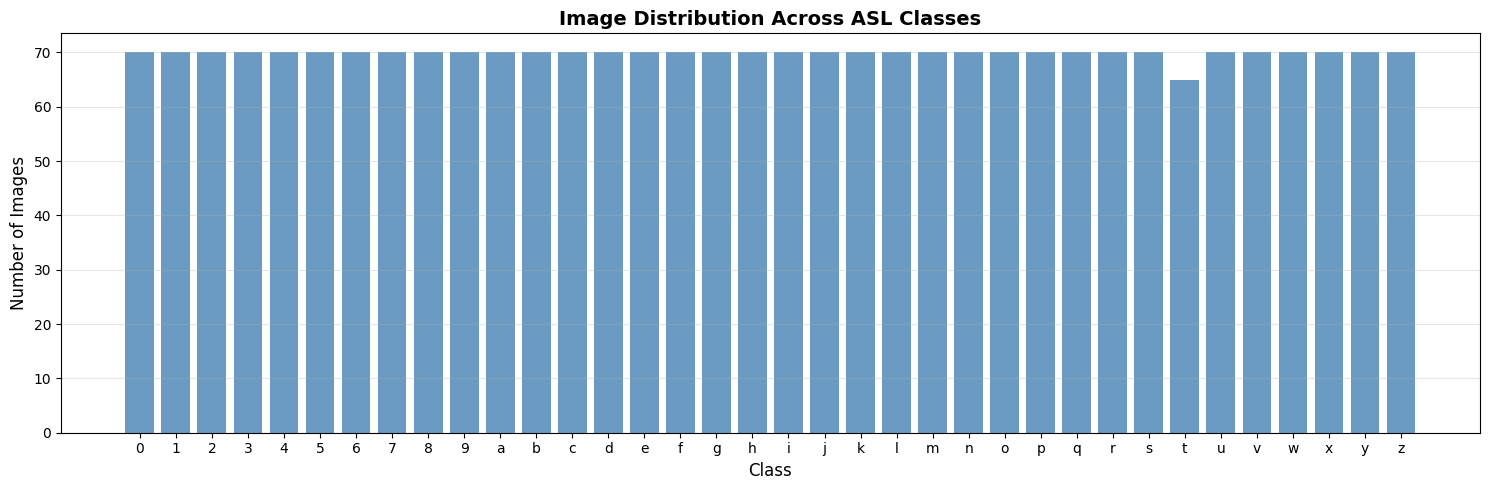


Dataset Balance Analysis:
Standard deviation: 0.83
Coefficient of variation: 1.19%
SUCCESS: Dataset is well-balanced (CV < 10%)


In [8]:
# Plot class distribution
plt.figure(figsize=(15, 5))
plt.bar(df_counts['Class'], df_counts['Image Count'], color='steelblue', alpha=0.8)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Image Distribution Across ASL Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Check if distribution is balanced
std_dev = df_counts['Image Count'].std()
mean_count = df_counts['Image Count'].mean()
cv = (std_dev / mean_count) * 100  # Coefficient of variation

print(f"\nDataset Balance Analysis:")
print(f"Standard deviation: {std_dev:.2f}")
print(f"Coefficient of variation: {cv:.2f}%")

if cv < 10:
    print("SUCCESS: Dataset is well-balanced (CV < 10%)")
elif cv < 25:
    print("WARNING: Dataset has moderate imbalance (10% <= CV < 25%)")
else:
    print("WARNING: Dataset has significant imbalance (CV >= 25%)")

## 6. Check Image Properties

In [9]:
# Sample images from each class and check properties
print("Checking image properties (sampling 5 images per class)...")

image_info = {
    'dimensions': defaultdict(int),
    'formats': defaultdict(int),
    'corrupted': [],
    'channels': defaultdict(int)
}

sample_size = 5
total_checked = 0

for class_dir in DATA_DIR.iterdir():
    if class_dir.is_dir():
        image_files = [f for f in class_dir.iterdir() 
                      if f.is_file() and f.suffix.lower() in valid_extensions]
        
        # Sample images from this class
        sampled = np.random.choice(image_files, 
                                  min(sample_size, len(image_files)), 
                                  replace=False)
        
        for img_path in sampled:
            try:
                img = cv2.imread(str(img_path))
                if img is None:
                    image_info['corrupted'].append(str(img_path))
                else:
                    h, w = img.shape[:2]
                    channels = img.shape[2] if len(img.shape) == 3 else 1
                    
                    image_info['dimensions'][f"{w}x{h}"] += 1
                    image_info['formats'][img_path.suffix.lower()] += 1
                    image_info['channels'][channels] += 1
                    total_checked += 1
            except Exception as e:
                image_info['corrupted'].append(str(img_path))

print(f"\nTotal images checked: {total_checked}")
print(f"\nImage Dimensions (sampled):")
for dim, count in sorted(image_info['dimensions'].items(), key=lambda x: -x[1])[:10]:
    print(f"  {dim}: {count} images")

print(f"\nImage Formats:")
for fmt, count in image_info['formats'].items():
    print(f"  {fmt}: {count} images")

print(f"\nColor Channels:")
for ch, count in image_info['channels'].items():
    channel_name = "Grayscale" if ch == 1 else f"Color ({ch} channels)"
    print(f"  {channel_name}: {count} images")

if image_info['corrupted']:
    print(f"\nWARNING: {len(image_info['corrupted'])} corrupted/unreadable images found:")
    for path in image_info['corrupted'][:10]:  # Show first 10
        print(f"  - {path}")
    if len(image_info['corrupted']) > 10:
        print(f"  ... and {len(image_info['corrupted']) - 10} more")
else:
    print("\nSUCCESS: No corrupted images found in sample")

Checking image properties (sampling 5 images per class)...

Total images checked: 180

Image Dimensions (sampled):
  400x400: 180 images

Image Formats:
  .jpeg: 180 images

Color Channels:
  Color (3 channels): 180 images

SUCCESS: No corrupted images found in sample


## 7. Display Sample Images

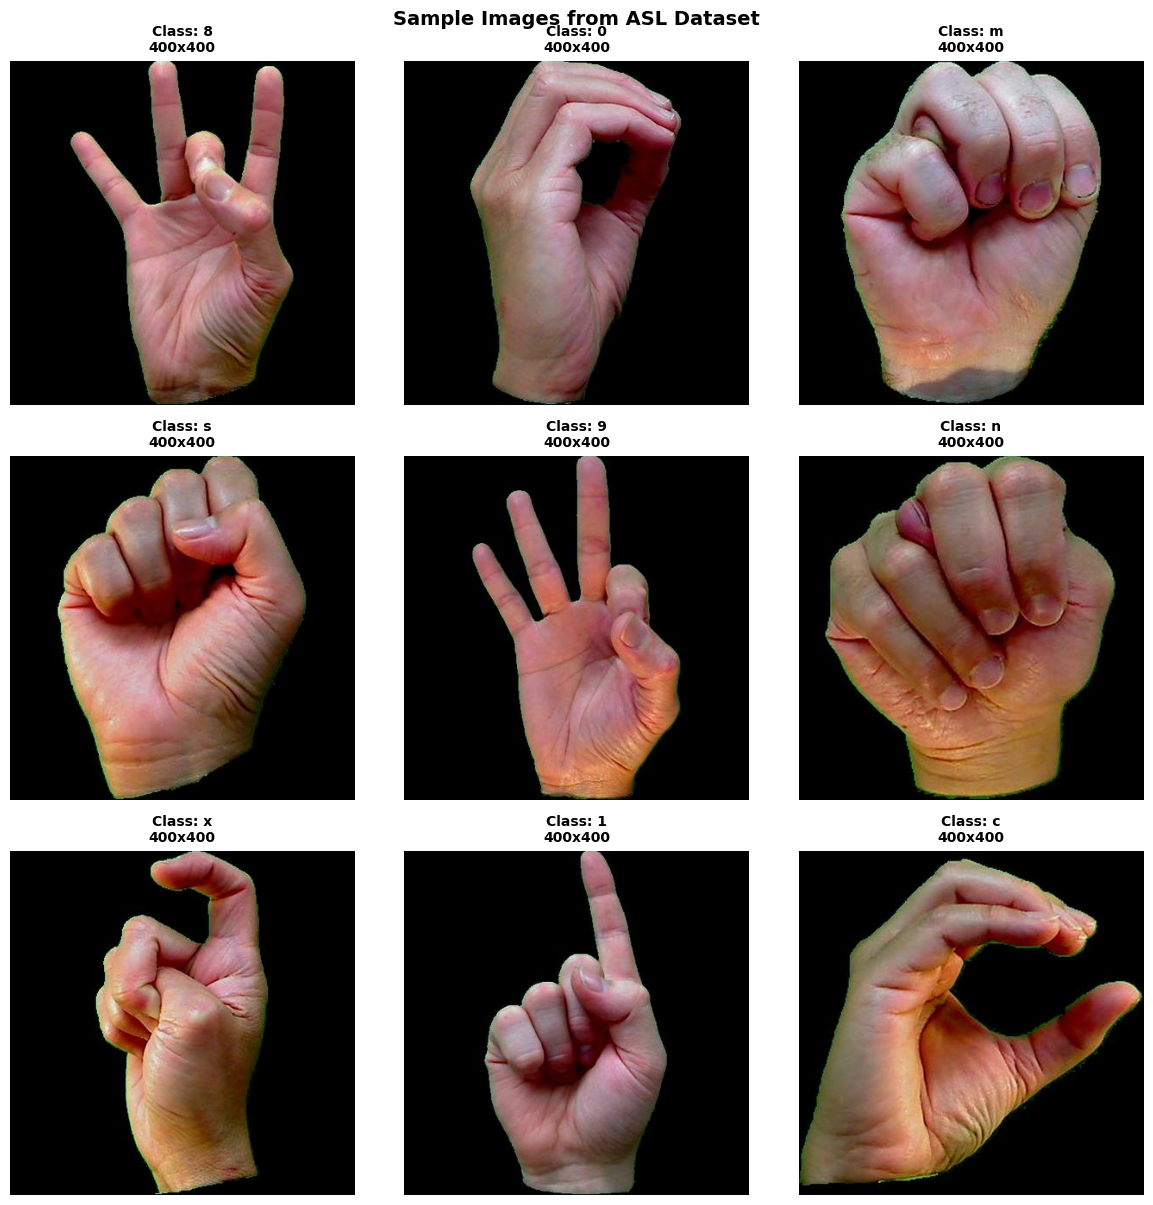

In [10]:
# Display sample images from random classes
num_samples = 9
sample_classes = np.random.choice(actual_classes, min(num_samples, len(actual_classes)), replace=False)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, class_name in enumerate(sample_classes):
    if idx >= num_samples:
        break
    
    class_path = DATA_DIR / class_name
    image_files = [f for f in class_path.iterdir() 
                  if f.is_file() and f.suffix.lower() in valid_extensions]
    
    if image_files:
        # Pick a random image from this class
        img_path = np.random.choice(image_files)
        img = cv2.imread(str(img_path))
        
        if img is not None:
            # Convert BGR to RGB for proper display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"Class: {class_name}\n{img.shape[1]}x{img.shape[0]}", 
                              fontsize=10, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f"Failed to load\nClass: {class_name}", 
                         ha='center', va='center')
            axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f"No images\nClass: {class_name}", 
                     ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from ASL Dataset', fontsize=14, fontweight='bold', y=1.00)
plt.show()

## 8. Quality Check Summary

In [11]:
# Generate final summary report
print("=" * 60)
print("ASL DATASET QUALITY CHECK SUMMARY")
print("=" * 60)

print(f"\nDataset Structure:")
print(f"  - Total classes: {len(actual_classes)}")
print(f"  - Expected classes: {len(expected_classes)}")
print(f"  - Missing classes: {len(missing_classes)}")
print(f"  - Total images: {df_counts['Image Count'].sum()}")

print(f"\nClass Distribution:")
print(f"  - Min images per class: {df_counts['Image Count'].min()}")
print(f"  - Max images per class: {df_counts['Image Count'].max()}")
print(f"  - Average images per class: {df_counts['Image Count'].mean():.2f}")
print(f"  - Balance (CV): {cv:.2f}%")

print(f"\nImage Quality (from sample):")
print(f"  - Total sampled: {total_checked}")
print(f"  - Corrupted/unreadable: {len(image_info['corrupted'])}")
print(f"  - Most common dimension: {max(image_info['dimensions'].items(), key=lambda x: x[1])[0]}")
print(f"  - Most common format: {max(image_info['formats'].items(), key=lambda x: x[1])[0]}")

print("\n" + "=" * 60)

# Overall assessment
issues_found = []
if missing_classes:
    issues_found.append(f"{len(missing_classes)} missing classes")
if len(empty_classes) > 0:
    issues_found.append(f"{len(empty_classes)} empty classes")
if cv >= 25:
    issues_found.append("significant class imbalance")
if image_info['corrupted']:
    issues_found.append(f"{len(image_info['corrupted'])} corrupted images in sample")

if issues_found:
    print("WARNING: ISSUES DETECTED:")
    for issue in issues_found:
        print(f"   - {issue}")
    print("\nRecommendation: Review and address the issues before training.")
else:
    print("SUCCESS: DATASET PASSED ALL QUALITY CHECKS")
    print("\nThe dataset appears to be clean and well-structured.")
    print("You can proceed with model training.")

print("=" * 60)

ASL DATASET QUALITY CHECK SUMMARY

Dataset Structure:
  - Total classes: 36
  - Expected classes: 36
  - Missing classes: 0
  - Total images: 2515

Class Distribution:
  - Min images per class: 65
  - Max images per class: 70
  - Average images per class: 69.86
  - Balance (CV): 1.19%

Image Quality (from sample):
  - Total sampled: 180
  - Corrupted/unreadable: 0
  - Most common dimension: 400x400
  - Most common format: .jpeg

SUCCESS: DATASET PASSED ALL QUALITY CHECKS

The dataset appears to be clean and well-structured.
You can proceed with model training.


## 9. Additional Checks (Added Later)

These additional checks were added after the initial notebook creation to gather more detailed information needed for model development.

### 9.1 Image Dimension Consistency Check

In [12]:
# Check if all images have consistent dimensions
print("Checking image dimension consistency across entire dataset...")

all_dimensions = []
dimension_counts = defaultdict(int)

for class_dir in DATA_DIR.iterdir():
    if class_dir.is_dir():
        image_files = [f for f in class_dir.iterdir() 
                      if f.is_file() and f.suffix.lower() in valid_extensions]
        
        for img_path in image_files:
            try:
                img = cv2.imread(str(img_path))
                if img is not None:
                    h, w = img.shape[:2]
                    dimension = f"{w}x{h}"
                    all_dimensions.append((w, h))
                    dimension_counts[dimension] += 1
            except Exception as e:
                pass

# Analyze dimension consistency
unique_dimensions = len(dimension_counts)
most_common_dim = max(dimension_counts.items(), key=lambda x: x[1])
total_images_checked = sum(dimension_counts.values())

print(f"\nDimension Analysis:")
print(f"  - Total images checked: {total_images_checked}")
print(f"  - Unique dimensions found: {unique_dimensions}")
print(f"  - Most common dimension: {most_common_dim[0]} ({most_common_dim[1]} images, {most_common_dim[1]/total_images_checked*100:.1f}%)")

print(f"\nTop 5 dimensions:")
for dim, count in sorted(dimension_counts.items(), key=lambda x: -x[1])[:5]:
    percentage = (count / total_images_checked) * 100
    print(f"  - {dim}: {count} images ({percentage:.1f}%)")

if unique_dimensions == 1:
    print("\nSUCCESS: All images have the same dimensions!")
elif most_common_dim[1] / total_images_checked > 0.95:
    print("\nINFO: Dataset is mostly consistent (>95% same dimension)")
else:
    print("\nWARNING: Images have varying dimensions - resizing will be needed")
    print(f"Recommendation: Resize all images to a standard size (e.g., 224x224 or 64x64)")

Checking image dimension consistency across entire dataset...

Dimension Analysis:
  - Total images checked: 2515
  - Unique dimensions found: 1
  - Most common dimension: 400x400 (2515 images, 100.0%)

Top 5 dimensions:
  - 400x400: 2515 images (100.0%)

SUCCESS: All images have the same dimensions!

Dimension Analysis:
  - Total images checked: 2515
  - Unique dimensions found: 1
  - Most common dimension: 400x400 (2515 images, 100.0%)

Top 5 dimensions:
  - 400x400: 2515 images (100.0%)

SUCCESS: All images have the same dimensions!


### 9.2 Color Mode Consistency Check

In [13]:
# Check color mode consistency (RGB vs Grayscale)
print("Checking color mode consistency...")

color_modes = {'RGB': 0, 'Grayscale': 0, 'Other': 0}
total_checked_color = 0

for class_dir in DATA_DIR.iterdir():
    if class_dir.is_dir():
        image_files = [f for f in class_dir.iterdir() 
                      if f.is_file() and f.suffix.lower() in valid_extensions]
        
        for img_path in image_files:
            try:
                img = cv2.imread(str(img_path))
                if img is not None:
                    if len(img.shape) == 2:
                        color_modes['Grayscale'] += 1
                    elif len(img.shape) == 3:
                        if img.shape[2] == 3:
                            color_modes['RGB'] += 1
                        else:
                            color_modes['Other'] += 1
                    total_checked_color += 1
            except Exception as e:
                pass

print(f"\nColor Mode Distribution:")
for mode, count in color_modes.items():
    if count > 0:
        percentage = (count / total_checked_color) * 100
        print(f"  - {mode}: {count} images ({percentage:.1f}%)")

if color_modes['RGB'] == total_checked_color:
    print("\nSUCCESS: All images are RGB (3 channels)")
elif color_modes['Grayscale'] == total_checked_color:
    print("\nINFO: All images are Grayscale (1 channel)")
    print("Recommendation: Convert to RGB if using pre-trained models")
else:
    print("\nWARNING: Mixed color modes detected")
    print("Recommendation: Standardize all images to RGB (3 channels)")

Checking color mode consistency...

Color Mode Distribution:
  - RGB: 2515 images (100.0%)

SUCCESS: All images are RGB (3 channels)

Color Mode Distribution:
  - RGB: 2515 images (100.0%)

SUCCESS: All images are RGB (3 channels)


### 9.3 File Size Statistics

In [14]:
# Check file size statistics
print("Analyzing file sizes...")

file_sizes = []
suspiciously_small = []
suspiciously_large = []

for class_dir in DATA_DIR.iterdir():
    if class_dir.is_dir():
        image_files = [f for f in class_dir.iterdir() 
                      if f.is_file() and f.suffix.lower() in valid_extensions]
        
        for img_path in image_files:
            try:
                size_bytes = img_path.stat().st_size
                size_kb = size_bytes / 1024
                file_sizes.append(size_kb)
                
                # Flag potentially problematic files
                if size_kb < 1:  # Less than 1 KB
                    suspiciously_small.append((str(img_path), size_kb))
                elif size_kb > 5000:  # Greater than 5 MB
                    suspiciously_large.append((str(img_path), size_kb))
            except Exception as e:
                pass

if file_sizes:
    file_sizes_array = np.array(file_sizes)
    
    print(f"\nFile Size Statistics:")
    print(f"  - Total files analyzed: {len(file_sizes)}")
    print(f"  - Average size: {file_sizes_array.mean():.2f} KB")
    print(f"  - Median size: {np.median(file_sizes_array):.2f} KB")
    print(f"  - Min size: {file_sizes_array.min():.2f} KB")
    print(f"  - Max size: {file_sizes_array.max():.2f} KB")
    print(f"  - Std deviation: {file_sizes_array.std():.2f} KB")
    
    if suspiciously_small:
        print(f"\nWARNING: {len(suspiciously_small)} suspiciously small files (< 1 KB):")
        for path, size in suspiciously_small[:5]:
            print(f"  - {path}: {size:.2f} KB")
        if len(suspiciously_small) > 5:
            print(f"  ... and {len(suspiciously_small) - 5} more")
    
    if suspiciously_large:
        print(f"\nINFO: {len(suspiciously_large)} large files (> 5 MB):")
        for path, size in suspiciously_large[:5]:
            print(f"  - {path}: {size:.2f} KB")
        if len(suspiciously_large) > 5:
            print(f"  ... and {len(suspiciously_large) - 5} more")
    
    if not suspiciously_small and not suspiciously_large:
        print("\nSUCCESS: All file sizes appear normal")
else:
    print("\nERROR: No files found to analyze")

Analyzing file sizes...

File Size Statistics:
  - Total files analyzed: 2515
  - Average size: 12.61 KB
  - Median size: 12.45 KB
  - Min size: 8.86 KB
  - Max size: 19.97 KB
  - Std deviation: 1.48 KB

SUCCESS: All file sizes appear normal


### 9.4 Recommended Model Input Configuration

In [15]:
# Generate recommendations for model configuration
print("=" * 60)
print("RECOMMENDED MODEL INPUT CONFIGURATION")
print("=" * 60)

print(f"\nBased on the analysis above, here are the recommendations:")
print(f"\n1. Number of Classes: {len(actual_classes)}")
print(f"   - Use this for the output layer of your model")

if unique_dimensions > 1:
    print(f"\n2. Input Image Size: Resize to standard size")
    print(f"   - Recommended: 64x64 or 128x128 (for faster training)")
    print(f"   - Alternative: 224x224 (if using transfer learning)")
else:
    most_common = max(dimension_counts.items(), key=lambda x: x[1])[0]
    print(f"\n2. Input Image Size: {most_common}")
    print(f"   - Images are already consistent")

if color_modes['RGB'] >= color_modes['Grayscale']:
    print(f"\n3. Color Channels: 3 (RGB)")
    if color_modes['Grayscale'] > 0:
        print(f"   - Convert grayscale images to RGB during loading")
else:
    print(f"\n3. Color Channels: 1 (Grayscale)")
    print(f"   - Consider converting to RGB if using pre-trained models")

print(f"\n4. Data Split Recommendation:")
print(f"   - Training: 70-80%")
print(f"   - Validation: 10-15%")
print(f"   - Testing: 10-15%")

print(f"\n5. Preprocessing Steps:")
print(f"   - Resize images to target size")
print(f"   - Normalize pixel values (divide by 255.0)")
if color_modes['Grayscale'] > 0 and color_modes['RGB'] > 0:
    print(f"   - Standardize color mode (convert all to RGB)")
print(f"   - Apply data augmentation (rotation, flip, zoom)")

print("\n" + "=" * 60)

RECOMMENDED MODEL INPUT CONFIGURATION

Based on the analysis above, here are the recommendations:

1. Number of Classes: 36
   - Use this for the output layer of your model

2. Input Image Size: 400x400
   - Images are already consistent

3. Color Channels: 3 (RGB)

4. Data Split Recommendation:
   - Training: 70-80%
   - Validation: 10-15%
   - Testing: 10-15%

5. Preprocessing Steps:
   - Resize images to target size
   - Normalize pixel values (divide by 255.0)
   - Apply data augmentation (rotation, flip, zoom)

